# TP n°4 : Skin lesion classification

### Le Guillouzic Maël

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule).

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [75]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# try:
#   import google.colab
#   IN_COLAB = True
#   print('You are using Google Colab')
#   !pip install googledrivedownloader
#   from googledrivedownloader import download_file_from_google_drive
# except:
#   IN_COLAB = False

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [76]:
# if IN_COLAB:
#   download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
#   dest_path='./data/features.csv')
#   download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
#   dest_path='./data/im/nevus-seg.jpg')
#   download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
#   dest_path='./data/im/nevus.jpg')
#   download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
#   dest_path='./data/im/melanoma-seg.jpg')
#   download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
#   dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data

In [77]:
## Read data
Working_directory="./data/"
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

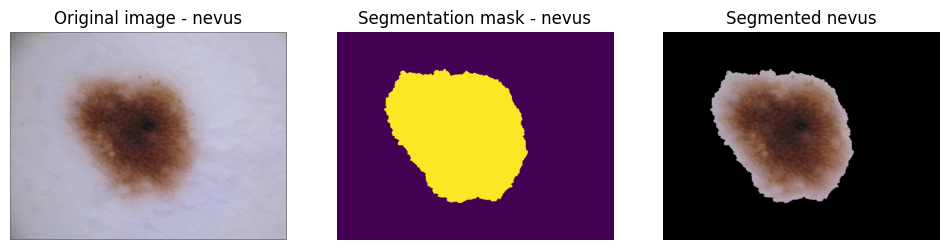

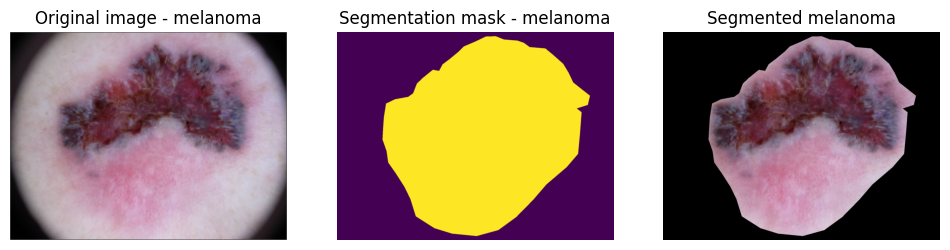

In [78]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg')
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg')
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [79]:
# Shuffle data randomly
np.random.seed(0)
index = np.random.permutation(N)
Xp, yp = X[index], y[index]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

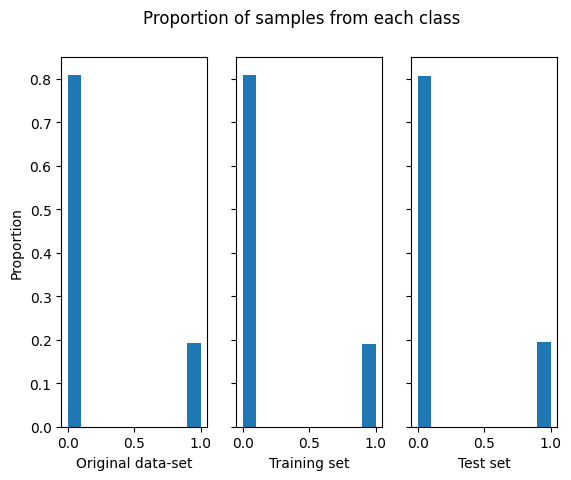

In [80]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=12,stratify=yp)

fig, axs = plt.subplots(1,3,sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

**Question :** As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

**Answer :** La première idée qu'on peut avoir (et que j'ai eu) est de soustraire à toutes les features leur moyenne, puis les diviser par $max(feature)-min(feature)$, et faire ceci sur le train puis sur le test.
Le problème est que la moyenne du test et du train sera différente, on applique une transformation différente au train et au test : il y a du **data leakage**.

La solution est de calculer la moyenne et $max(feature)-min(feature)$, puis d'effctuer le scale sur le train et le test avec ces valeurs. StandartScaler le fait pour nous avec le code ci dessous :

In [81]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices.

---

**Question**: Comment the results.

**Answer :** On observe que les lésions bégnines sont quasi systématiquement bien classées (91% pour LDA et 94% pour QDA), mais par contre les mélanones sont quasiment tous mals classés. LDA s'en sort un tout petit peu mieux mais reste loin d'etre satisfaisant.

On pouvait s'attendre a ce résultat au vu du déséquilibre des 2 classes.

Néanmoins, ce résultat n'est pas du tout satisfaisant, puisque ne pas détecter un mélanome potentiellement dangereux (faux négatif je crois) peut etre très grave pour le patient tandis qu'avoir des faux positifs engendre au pire des cas une revérification du médecin.

---


Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       145
           1       0.46      0.31      0.37        35

    accuracy                           0.79       180
   macro avg       0.65      0.61      0.62       180
weighted avg       0.77      0.79      0.78       180

Normalized confusion matrix
[[0.91034483 0.08965517]
 [0.68571429 0.31428571]]


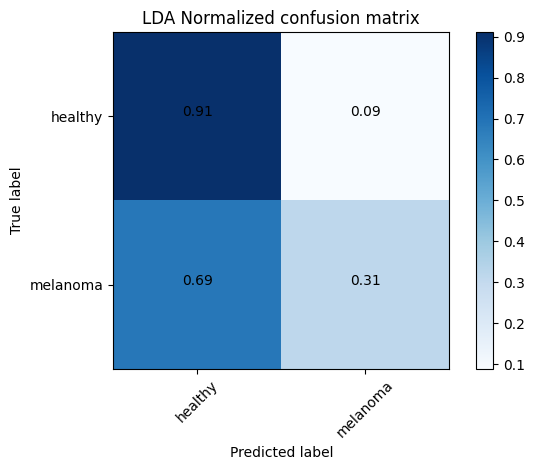

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       145
           1       0.43      0.17      0.24        35

    accuracy                           0.79       180
   macro avg       0.63      0.56      0.56       180
weighted avg       0.75      0.79      0.76       180

Normalized confusion matrix
[[0.94482759 0.05517241]
 [0.82857143 0.17142857]]


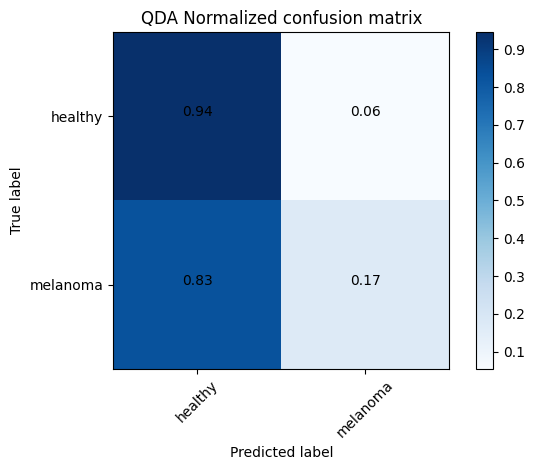

In [82]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test,y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()


---

**Question :** The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

**Answer :** On pourrait tester une cross validation pour réduire le biais.

Mais c'est étrange car quand on met en place une validation croisée (cf ci dessous), on obtient des perfomances plus moyennes ... Cela peut paraitre cohérent puisqu'on entraine chaque fold sur moins de données donc ils va moins over fitter.

---


Fitting LDA with cross-validation
Accuracy: 0.79 (+/- 0.07)
Time: 0.027144908905029297 seconds 

Normalized confusion matrix
[[0.91176471 0.08823529]
 [0.7375     0.2625    ]]


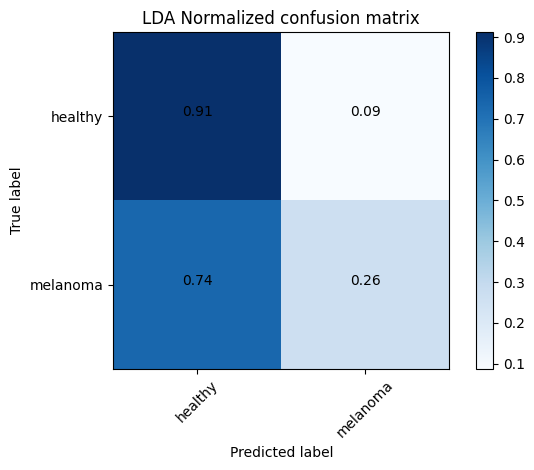

Fitting QDA with cross-validation
Accuracy: 0.80 (+/- 0.06)
Time: 0.006342887878417969 seconds

Normalized confusion matrix
[[0.93823529 0.06176471]
 [0.7875     0.2125    ]]


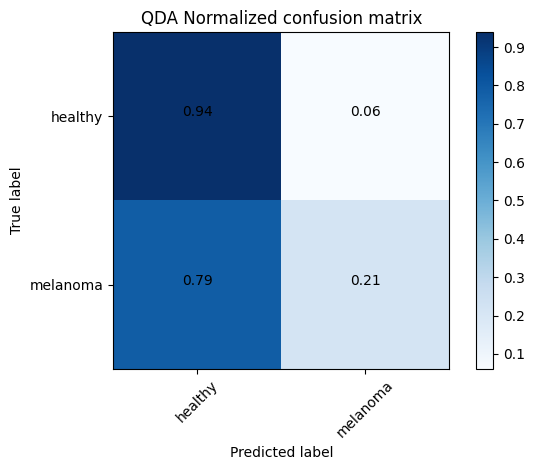

Fitting K-nearest neighbour with cross-validation
Accuracy: 0.79 (+/- 0.05)
Time: 0.006278038024902344 seconds
Normalized confusion matrix
[[0.91470588 0.08529412]
 [0.725      0.275     ]]


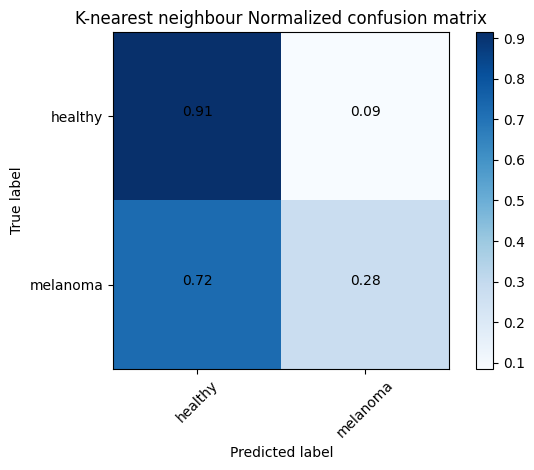

In [83]:
# Fitting LDA with cross-validation and plot the confusion matrix
print("Fitting LDA with cross-validation")
t0 = time()
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_train_scale, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Time: {0} seconds \n".format(time() - t0))
y_pred_cv = cross_val_predict(lda, X_train_scale, y_train, cv=5)
cnf_matrix = confusion_matrix(y_train, y_pred_cv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA with cross-validation")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_train_scale, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Time: {0} seconds\n".format(time() - t0))
y_pred_cv = cross_val_predict(qda, X_train_scale, y_train, cv=5)
cnf_matrix = confusion_matrix(y_train, y_pred_cv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour with cross-validation")
t0 = time()
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X_train_scale, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Time: {0} seconds".format(time() - t0))
y_pred_cv = cross_val_predict(knn, X_train_scale, y_train, cv=5)
cnf_matrix = confusion_matrix(y_train, y_pred_cv)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='K-nearest neighbour Normalized confusion matrix')
plt.show()



---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation.

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

**Answer :** On obtient des mélanomes très mal classifiés ... c'est catastrophique. A mon avis cela survient car, les lésions bégnines étant tellement prédominantes, notre modèle maximise son accuracy en classifiant TOUT en bénin. Seul problème, ce n'est pas du tout ce qu'on veut puisque idéalement on veut minimiser au plus les faux négatifs.

---

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8166666666666667 

Best training params: {'kneighborsclassifier__n_neighbors': 4} 

Normalized confusion matrix
[[0.96551724 0.03448276]
 [0.85714286 0.14285714]]


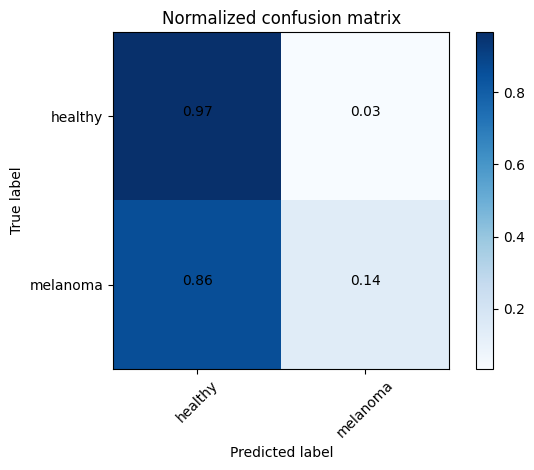

In [84]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {} \n".format(grid_KNN.best_score_))
print("Best training params: {} \n".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions.

---

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer: Avec le Recall et le F1 c'est bien meilleur !"

---


Ajustement KNN scores differents

Critere: accuracy
Score entrainement: 0.817
Parametre: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.96551724 0.03448276]
 [0.85714286 0.14285714]]


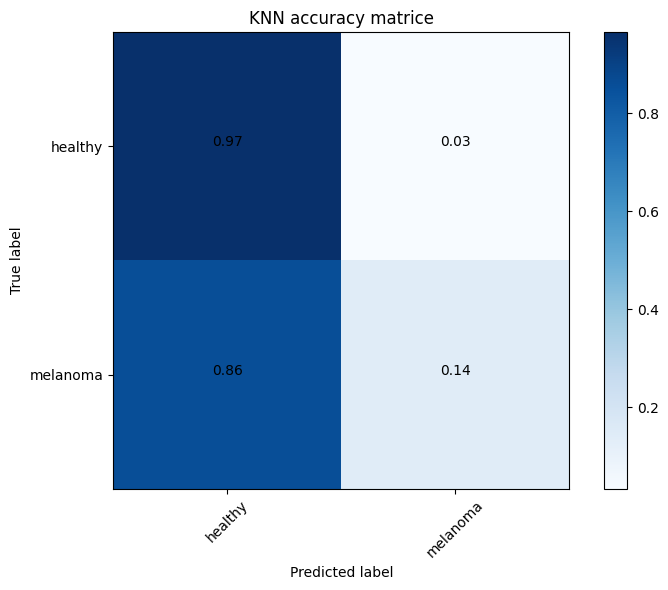


Rapport classification accuracy
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       145
           1       0.50      0.14      0.22        35

    accuracy                           0.81       180
   macro avg       0.66      0.55      0.56       180
weighted avg       0.76      0.81      0.76       180


Critere: recall
Score entrainement: 0.412
Parametre: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.83448276 0.16551724]
 [0.57142857 0.42857143]]


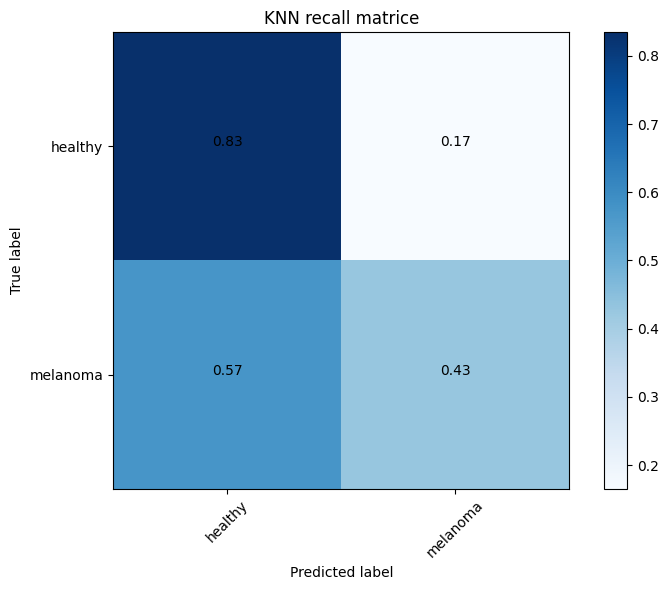


Rapport classification recall
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       145
           1       0.38      0.43      0.41        35

    accuracy                           0.76       180
   macro avg       0.62      0.63      0.63       180
weighted avg       0.77      0.76      0.76       180


Critere: f1
Score entrainement: 0.420
Parametre: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.83448276 0.16551724]
 [0.57142857 0.42857143]]


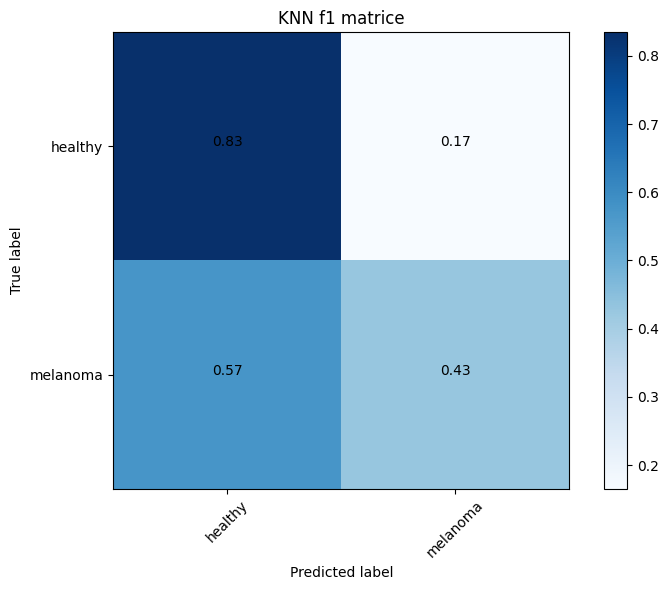


Rapport classification f1
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       145
           1       0.38      0.43      0.41        35

    accuracy                           0.76       180
   macro avg       0.62      0.63      0.63       180
weighted avg       0.77      0.76      0.76       180


Critere: balanced_accuracy
Score entrainement: 0.639
Parametre: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.83448276 0.16551724]
 [0.57142857 0.42857143]]


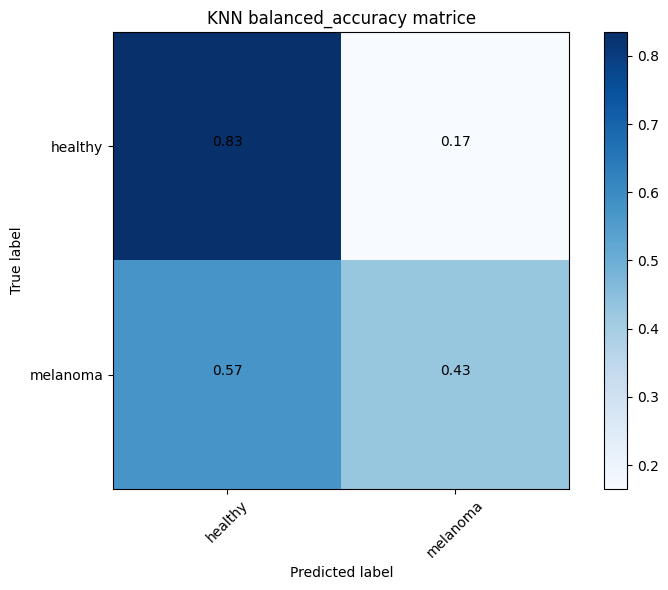


Rapport classification balanced_accuracy
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       145
           1       0.38      0.43      0.41        35

    accuracy                           0.76       180
   macro avg       0.62      0.63      0.63       180
weighted avg       0.77      0.76      0.76       180


Resume meilleurs parametres scores
accuracy: K=4, Score=0.817
recall: K=1, Score=0.412
f1: K=1, Score=0.420
balanced_accuracy: K=1, Score=0.639


In [85]:
# recherche hyperparametres scores
print("Ajustement KNN scores differents")

voisin = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid_knn = {'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

metriques = ['accuracy', 'recall', 'f1', 'balanced_accuracy']
best_params = {}
meilleurs_scores = {}

for critere in metriques:
    knn_grid = GridSearchCV(estimator=voisin, param_grid=param_grid_knn, scoring=critere, cv=5)
    knn_grid.fit(X_train, y_train)
    best_params[critere] = knn_grid.best_params_
    meilleurs_scores[critere] = knn_grid.best_score_
    
    print(f"\nCritere: {critere}")
    print(f"Score entrainement: {knn_grid.best_score_:.3f}")
    print(f"Parametre: {knn_grid.best_params_}")
    
    # pred test conf matrice
    predits = knn_grid.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predits)
    
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                          title=f'KNN {critere} matrice')
    plt.show()
    
    print(f"\nRapport classification {critere}")
    print(classification_report(y_test, predits))

print("\nResume meilleurs parametres scores")
for critere in metriques:
    print(f"{critere}: K={best_params[critere]['kneighborsclassifier__n_neighbors']}, Score={meilleurs_scores[critere]:.3f}")

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage.

In [86]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 340), (1, 328)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set.

---

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

**Answer :** Avec du recall sur de l'oversample ca commence à être pas mal ! 0.66 sur les melanoma, ce sont les meilleures performances depuis le début.

---


Ajustement KNN cv oversample
Distribution classes train
[(0, 340), (1, 80)]

Distribution classes resample
[(0, 340), (1, 328)]

Critere accuracy
Score cv 0.874
Meilleur K 2
Normalized confusion matrix
[[0.8137931  0.1862069 ]
 [0.51428571 0.48571429]]


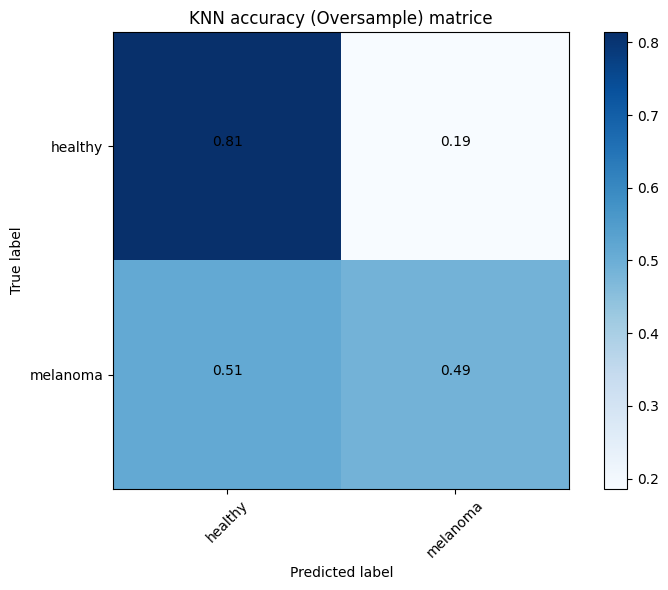


Rapport classification accuracy test
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       145
           1       0.39      0.49      0.43        35

    accuracy                           0.75       180
   macro avg       0.63      0.65      0.64       180
weighted avg       0.77      0.75      0.76       180


Critere recall
Score cv 0.991
Meilleur K 1
Normalized confusion matrix
[[0.71724138 0.28275862]
 [0.34285714 0.65714286]]


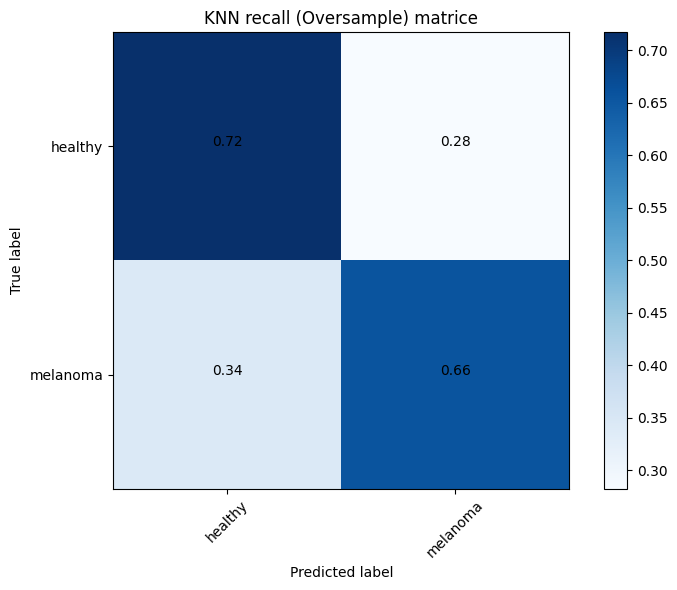


Rapport classification recall test
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       145
           1       0.36      0.66      0.46        35

    accuracy                           0.71       180
   macro avg       0.63      0.69      0.63       180
weighted avg       0.79      0.71      0.73       180


Critere f1
Score cv 0.881
Meilleur K 2
Normalized confusion matrix
[[0.8137931  0.1862069 ]
 [0.51428571 0.48571429]]


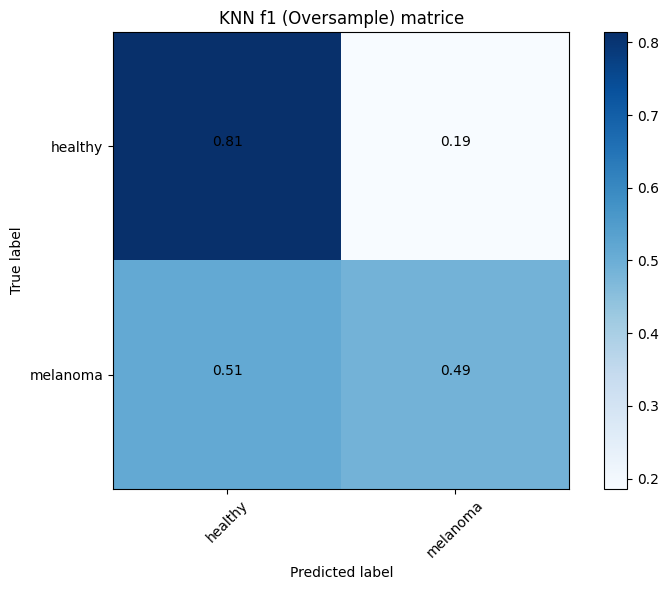


Rapport classification f1 test
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       145
           1       0.39      0.49      0.43        35

    accuracy                           0.75       180
   macro avg       0.63      0.65      0.64       180
weighted avg       0.77      0.75      0.76       180


Critere balanced_accuracy
Score cv 0.876
Meilleur K 2
Normalized confusion matrix
[[0.8137931  0.1862069 ]
 [0.51428571 0.48571429]]


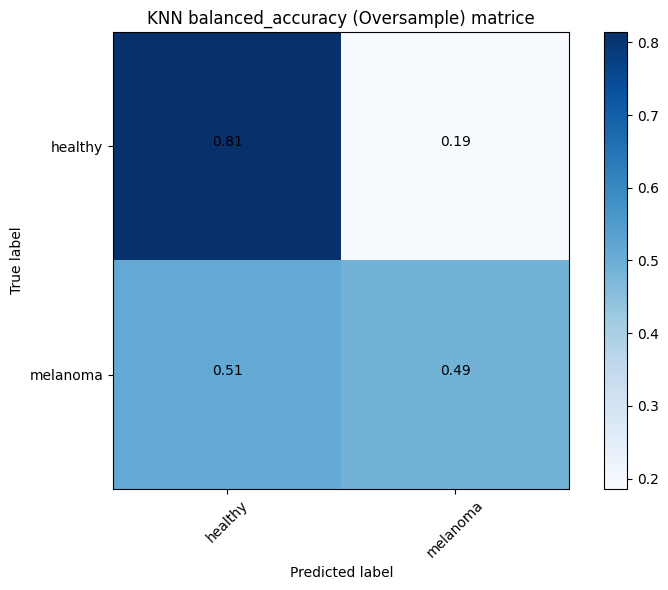


Rapport classification balanced_accuracy test
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       145
           1       0.39      0.49      0.43        35

    accuracy                           0.75       180
   macro avg       0.63      0.65      0.64       180
weighted avg       0.77      0.75      0.76       180


Resume parametres scores oversample
accuracy: K=2, Score cv=0.874
recall: K=1, Score cv=0.991
f1: K=2, Score cv=0.881
balanced_accuracy: K=2, Score cv=0.876


In [87]:
# ajustement KNN cv oversample
print("Ajustement KNN cv oversample")

voisin = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid_knn = {'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

metriques = ['accuracy', 'recall', 'f1', 'balanced_accuracy']
best_params_resampled = {}
meilleurs_scores_resampled = {}

print("Distribution classes train")
print(sorted(Counter(y_train).items()))
print("\nDistribution classes resample")
print(sorted(Counter(y_resampled).items()))

for critere in metriques:
    knn_grid = GridSearchCV(estimator=voisin, param_grid=param_grid_knn, scoring=critere, cv=5)
    knn_grid.fit(X_resampled, y_resampled)
    best_params_resampled[critere] = knn_grid.best_params_
    meilleurs_scores_resampled[critere] = knn_grid.best_score_
    
    print(f"\nCritere {critere}")
    print(f"Score cv {knn_grid.best_score_:.3f}")
    print(f"Meilleur K {knn_grid.best_params_['kneighborsclassifier__n_neighbors']}")
    
    # pred test matrice
    predits = knn_grid.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predits)
    
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                          title=f'KNN {critere} (Oversample) matrice')
    plt.show()
    
    print(f"\nRapport classification {critere} test")
    print(classification_report(y_test, predits))

print("\nResume parametres scores oversample")
for critere in metriques:
    print(f"{critere}: K={best_params_resampled[critere]['kneighborsclassifier__n_neighbors']}, Score cv={meilleurs_scores_resampled[critere]:.3f}")

Let's use the techniques seen today: Perceptron and linear SVM.

In [88]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))
print("")

# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.009185586535436885
 Average and std TEST CV accuracy : 0.8133333333333332 +- 0.027182510717166816


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [89]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))
print("\n")

# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
 Average and std TRAIN CV f1 : 0.35373231691129065 +- 0.09920379279242053
 Average and std TEST CV f1 : 0.31268115942028984 +- 0.13015303261005437


Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.009185586535436885
 Average and std TEST CV accuracy : 0.8133333333333332 +- 0.027182510717166816
 Average and std TRAIN CV f1 : 0.4252553659959172 +- 0.05262498335231036
 Average and std TEST CV f1 : 0.3061355832655643 +- 0.11113463375312656


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)

In [90]:
from imblearn.pipeline import make_pipeline as make_pipeline2

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM with oversampling
print("\nFitting Linear SVM with oversampling")
Lsvm_os = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
Lsvm_os_cv = cross_validate(Lsvm_os, Xp, yp, cv=5, scoring=('accuracy', 'f1'), return_train_score=True)

print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_os_cv['train_accuracy'].mean(), Lsvm_os_cv['train_accuracy'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_os_cv['test_accuracy'].mean(), Lsvm_os_cv['test_accuracy'].std()))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_os_cv['train_f1'].mean(), Lsvm_os_cv['train_f1'].std()))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_os_cv['test_f1'].mean(), Lsvm_os_cv['test_f1'].std()))

# Compare results between original and oversampled data
print("\nComparison of Linear SVM with and without oversampling:")
print("                   | Original Data         | Oversampled Data")
print("-------------------|-----------------------|----------------------")
print("Test Accuracy      | {0:.3f} +- {1:.3f}    | {2:.3f} +- {3:.3f}".format(
    Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std(),
    Lsvm_os_cv['test_accuracy'].mean(), Lsvm_os_cv['test_accuracy'].std()))
print("Test F1 Score      | {0:.3f} +- {1:.3f}    | {2:.3f} +- {3:.3f}".format(
    Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std(),
    Lsvm_os_cv['test_f1'].mean(), Lsvm_os_cv['test_f1'].std()))

# Also compare Perceptron results
print("\nComparison of Perceptron with and without oversampling:")
print("                   | Original Data         | Oversampled Data")
print("-------------------|-----------------------|----------------------")
print("Test Accuracy      | {0:.3f} +- {1:.3f}    | {2:.3f} +- {3:.3f}".format(
    Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std(),
    Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std()))
print("Test F1 Score      | {0:.3f} +- {1:.3f}    | {2:.3f} +- {3:.3f}".format(
    Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std(),
    Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std()))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6779166666666667 +- 0.06692138837637952
 Average and std TEST CV accuracy : 0.64 +- 0.08698658900466592
 Average and std TRAIN CV f1 : 0.43482291727742783 +- 0.06267577882127977
 Average and std TEST CV f1 : 0.3819810575100647 +- 0.056281050480672015

Fitting Linear SVM with oversampling
 Average and std TRAIN CV accuracy : 0.7575000000000001 +- 0.01470780216226901
 Average and std TEST CV accuracy : 0.6966666666666667 +- 0.05286250509051238
 Average and std TRAIN CV f1 : 0.5217456374731981 +- 0.0302379675878656
 Average and std TEST CV f1 : 0.41094336951343396 +- 0.06959177397845218

Comparison of Linear SVM with and without oversampling:
                   | Original Data         | Oversampled Data
-------------------|-----------------------|----------------------
Test Accuracy      | 0.813 +- 0.027    | 0.697 +- 0.053
Test F1 Score

We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data.
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data.

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6946428571428571 +- 0.0738095238095238
 Average and std TEST CV accuracy : 0.6190476190476192 +- 0.059285236180898725
 Average and std TRAIN CV f1 : 0.47324708318644665 +- 0.0830839920548311
 Average and std TEST CV f1 : 0.34589546553084505 +- 0.0429412773362507
Normalized confusion matrix
[[0.69655172 0.30344828]
 [0.57142857 0.42857143]]


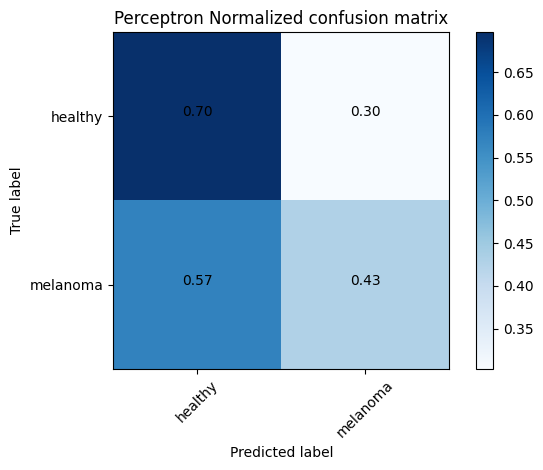


Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7857142857142858 +- 0.023130189556816033
 Average and std TEST CV accuracy : 0.7404761904761905 +- 0.042190583682546065
 Average and std TRAIN CV f1 : 0.5750979405561661 +- 0.0377287566086442
 Average and std TEST CV f1 : 0.4543049484175555 +- 0.0592865318365955
 Average and std TEST CV recall : 0.5625 +- 0.06846531968814576
Normalized confusion matrix
[[0.75172414 0.24827586]
 [0.51428571 0.48571429]]


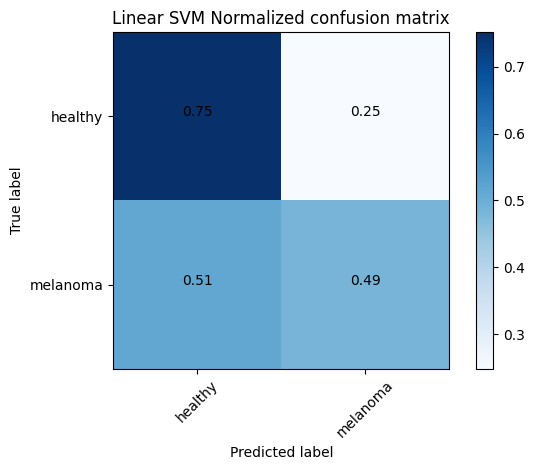


Comparison between Perceptron and Linear SVM on test set:
Model      | Accuracy | Precision | Recall | F1 Score
-----------|----------|-----------|--------|--------
Perceptron | 0.6444   | 0.2542    | 0.4286 | 0.3191
Linear SVM | 0.7000   | 0.3208    | 0.4857 | 0.3864

Perceptron Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       145
           1       0.25      0.43      0.32        35

    accuracy                           0.64       180
   macro avg       0.54      0.56      0.54       180
weighted avg       0.72      0.64      0.67       180


Linear SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       145
           1       0.32      0.49      0.39        35

    accuracy                           0.70       180
   macro avg       0.59      0.62      0.59       180
weighted avg       0.75      0.70      0.72       180



In [91]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Perceptron Normalized confusion matrix')
plt.show()


# Fitting linear SVM
print("\nFitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC(max_iter=2000))
Lsvm_cv = cross_validate(Lsvm, X_train, y_train, cv=5, 
                         scoring=('accuracy', 'f1', 'recall'), 
                         return_train_score=True, return_estimator=True)

print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std()))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std()))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std()))
print(" Average and std TEST CV recall : {0} +- {1}".format(Lsvm_cv['test_recall'].mean(), Lsvm_cv['test_recall'].std()))


index_best_svm = np.argmax(Lsvm_cv['test_f1'])  # F1 instead of accuracy
estimator_best_svm = Lsvm_cv['estimator'][index_best_svm]
y_pred_svm = estimator_best_svm.predict(X_test)
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
                     title='Linear SVM Normalized confusion matrix')
plt.show()

# Compare with the best perceptron model
print("\nComparison between Perceptron and Linear SVM on test set:")
print("Model      | Accuracy | Precision | Recall | F1 Score")
print("-----------|----------|-----------|--------|--------")
perc_metrics = classification_report(y_test, y_pred, output_dict=True)
svm_metrics = classification_report(y_test, y_pred_svm, output_dict=True)
print("Perceptron | {:.4f}   | {:.4f}    | {:.4f} | {:.4f}".format(
    perc_metrics['accuracy'], 
    perc_metrics['1']['precision'], 
    perc_metrics['1']['recall'], 
    perc_metrics['1']['f1-score']))
print("Linear SVM | {:.4f}   | {:.4f}    | {:.4f} | {:.4f}".format(
    svm_metrics['accuracy'], 
    svm_metrics['1']['precision'], 
    svm_metrics['1']['recall'], 
    svm_metrics['1']['f1-score']))

print("\nPerceptron Classification Report:")
print(classification_report(y_test, y_pred))
print("\nLinear SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model.

---

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

**Answer :** See code ci dessous

---

Finding the best C parameter for Linear SVM with oversampled data
Best F1 Score: 0.480
Best parameter set: {'linearsvc__C': 0.01}

Scores for best C value:
accuracy: 0.750 ± 0.046
f1: 0.480 ± 0.069
recall: 0.600 ± 0.075
precision: 0.403 ± 0.069
Normalized confusion matrix
[[0.7862069  0.2137931 ]
 [0.48571429 0.51428571]]


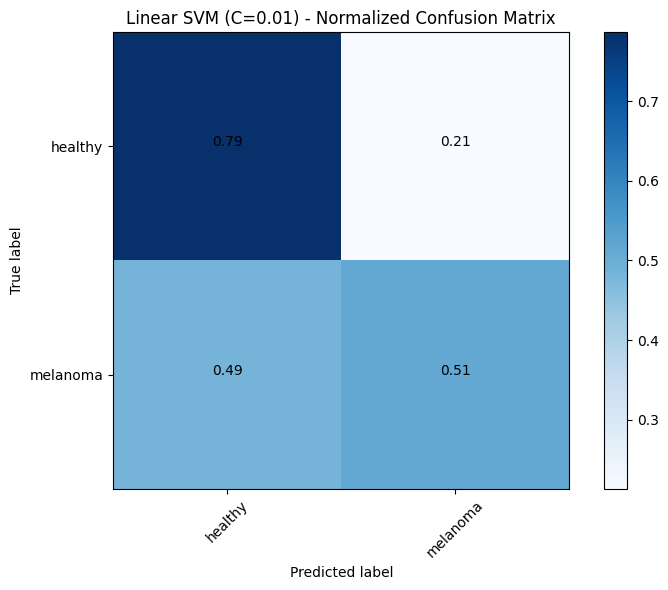


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       145
           1       0.37      0.51      0.43        35

    accuracy                           0.73       180
   macro avg       0.62      0.65      0.63       180
weighted avg       0.77      0.73      0.75       180



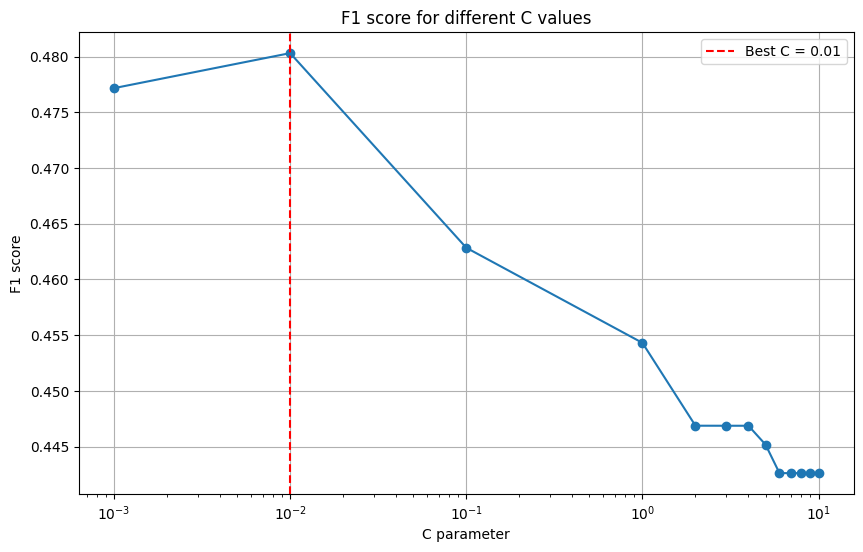

In [92]:
# Looking for the best hyperparameter C
print("Finding the best C parameter for Linear SVM with oversampled data")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC(max_iter=2000))
p_grid_lsvm = {'linearsvc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1]}

# Using multiple scoring metrics with GridSearchCV
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# refit='f1' means the best model will be chosen based on f1 score
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, 
                        scoring=scoring, cv=5, refit='f1')
grid_lsvm.fit(X_train, y_train)

print(f"Best F1 Score: {grid_lsvm.best_score_:.3f}")
print(f"Best parameter set: {grid_lsvm.best_params_}")

print("\nScores for best C value:")
best_C = grid_lsvm.best_params_['linearsvc__C']
best_index = grid_lsvm.cv_results_['param_linearsvc__C'].data.tolist().index(best_C)
for metric in scoring.keys():
    score = grid_lsvm.cv_results_[f'mean_test_{metric}'][best_index]
    std = grid_lsvm.cv_results_[f'std_test_{metric}'][best_index]
    print(f"{metric}: {score:.3f} ± {std:.3f}")


y_pred = grid_lsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                    title=f'Linear SVM (C={best_C}) - Normalized Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
C_values = grid_lsvm.cv_results_['param_linearsvc__C'].data
f1_scores = grid_lsvm.cv_results_['mean_test_f1']
plt.semilogx(C_values, f1_scores, 'o-')
plt.axvline(best_C, color='r', linestyle='--', label=f'Best C = {best_C}')
plt.xlabel('C parameter')
plt.ylabel('F1 score')
plt.title('F1 score for different C values')
plt.grid(True)
plt.legend()
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

---

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

**Answer :** Voir code ci dessous 

---


Fitting Non-linear SVM to the training set


/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mlg/venv-ai/lib/python3.10/site-packages/s

Best F1 Score: 0.504
Best parameters: C=5, gamma=0.0005

Scores for best parameters:
accuracy: 0.750 ± 0.036
f1: 0.504 ± 0.051
recall: 0.662 ± 0.050
precision: 0.408 ± 0.050
Normalized confusion matrix
[[0.77241379 0.22758621]
 [0.48571429 0.51428571]]


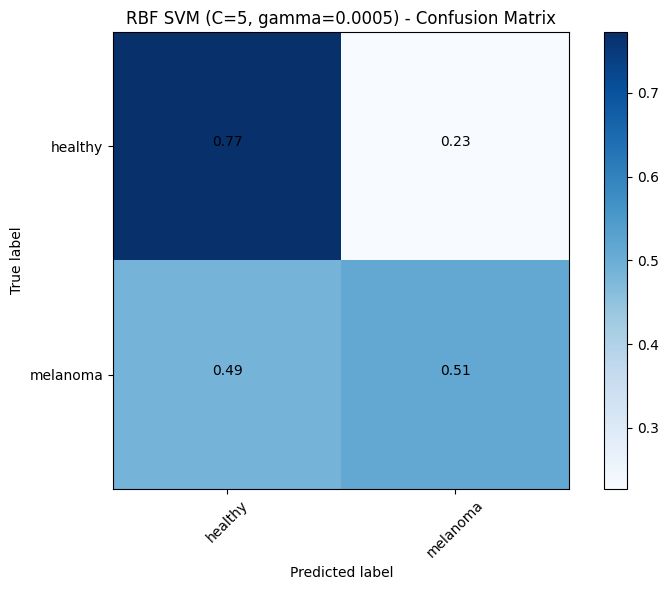


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       145
           1       0.35      0.51      0.42        35

    accuracy                           0.72       180
   macro avg       0.61      0.64      0.62       180
weighted avg       0.77      0.72      0.74       180



In [93]:
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1],'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# Use refit='f1' to select best model based on F1 score
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, 
                         scoring=scoring, cv=5, refit='f1')
grid_nlsvm.fit(X_train, y_train)
best_C = grid_nlsvm.best_params_['svc__C']
best_gamma = grid_nlsvm.best_params_['svc__gamma']
print(f"Best F1 Score: {grid_nlsvm.best_score_:.3f}")
print(f"Best parameters: C={best_C}, gamma={best_gamma}")
best_idx = grid_nlsvm.best_index_
print("\nScores for best parameters:")
for metric in scoring.keys():
    score = grid_nlsvm.cv_results_[f'mean_test_{metric}'][best_idx]
    std = grid_nlsvm.cv_results_[f'std_test_{metric}'][best_idx]
    print(f"{metric}: {score:.3f} ± {std:.3f}")

y_pred = grid_nlsvm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                    title=f'RBF SVM (C={best_C}, gamma={best_gamma}) - Confusion Matrix')
plt.show()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


---

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer :** J'ai les mêmes résultats entre linear et non linear SVM ...

---



Entrainement Standard pipeline avec accuracy score

Entrainement Standard pipeline avec f1 score

Entrainement Standard pipeline avec recall score

Entrainement Oversampled pipeline avec accuracy score

Entrainement Oversampled pipeline avec f1 score

Entrainement Oversampled pipeline avec recall score

Comparaison recall melanoma
Oversampled_f1: Rappel=0.514, F1=0.439, Precision=0.383, Exactitude=0.744
Oversampled_recall: Rappel=0.514, F1=0.439, Precision=0.383, Exactitude=0.744
Standard_f1: Rappel=0.343, F1=0.480, Precision=0.800, Exactitude=0.856
Standard_recall: Rappel=0.343, F1=0.480, Precision=0.800, Exactitude=0.856
Oversampled_accuracy: Rappel=0.171, F1=0.245, Precision=0.429, Exactitude=0.794
Standard_accuracy: Rappel=0.114, F1=0.190, Precision=0.571, Exactitude=0.811


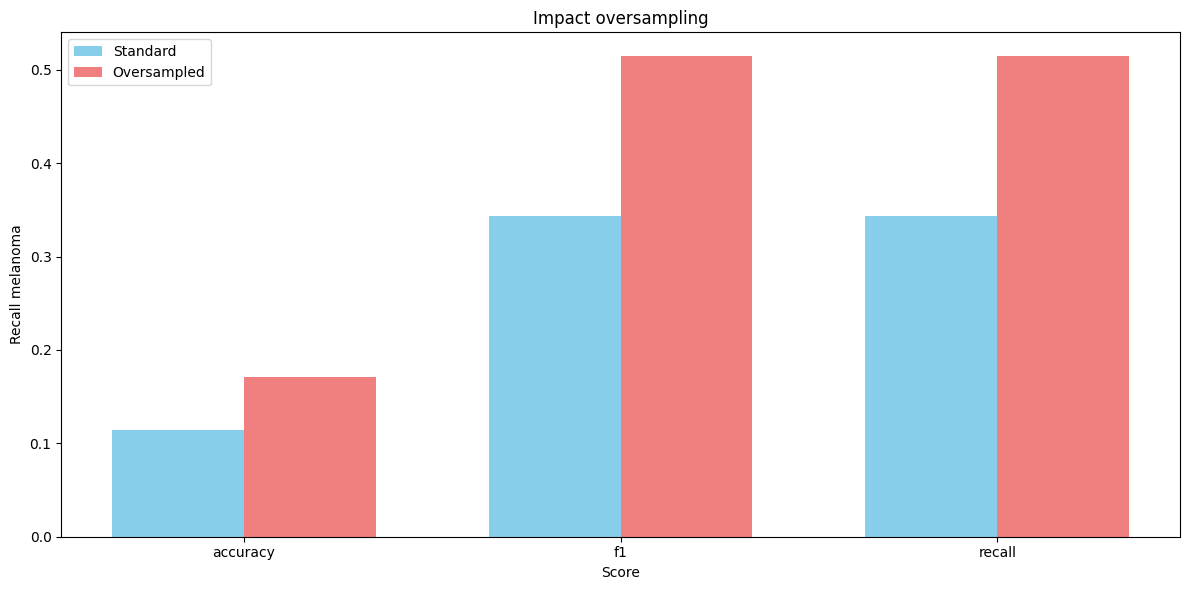

In [99]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, classification_report

# pipeline standard sans oversampling
pipeline_standard = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
# pipeline avec oversampling ADASYN
pipeline_over = make_pipeline_imb(ADASYN(random_state=42), StandardScaler(), SVC(kernel='rbf'))

param_grille = {'svc__C': [0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1]}
scoring_metrics = {'accuracy': 'accuracy', 'f1': 'f1', 'recall': 'recall'}
resultats = {}

# test pipelines scores
for nom_pipe, pipeline in [('Standard', pipeline_standard), ('Oversampled', pipeline_over)]:
    for nom_score, score_func in scoring_metrics.items():
        print(f"\nEntrainement {nom_pipe} pipeline avec {nom_score} score")
        grille_cv = GridSearchCV(pipeline, param_grille, cv=5, scoring=score_func, refit=True)
        grille_cv.fit(X_train, y_train)
        y_pred = grille_cv.predict(X_test)
        clef = f"{nom_pipe}_{nom_score}"
        resultats[clef] = {
            'best_params': grille_cv.best_params_,
            'best_cv_score': grille_cv.best_score_,
            'accuracy': accuracy_score(y_test, y_pred),
            'rappel': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        # parametres et scores (commentes)
        # print(f"Parametres: {grille_cv.best_params_}")
        # print(f"Score cv {nom_score}: {grille_cv.best_score_:.3f}")
        # print(f"Exactitude: {resultats[clef]['accuracy']:.3f}")
        # print(f"Rappel: {resultats[clef]['rappel']:.3f}")
        # print(f"Precision: {resultats[clef]['precision']:.3f}")
        # print(f"F1: {resultats[clef]['f1']:.3f}")

print("\nComparaison recall melanoma")
for clef in sorted(resultats.keys(), key=lambda x: resultats[x]['rappel'], reverse=True):
    rappel = resultats[clef]['rappel']
    f1 = resultats[clef]['f1']
    precision = resultats[clef]['precision']
    exactitude = resultats[clef]['accuracy']
    print(f"{clef}: Rappel={rappel:.3f}, F1={f1:.3f}, Precision={precision:.3f}, Exactitude={exactitude:.3f}")

plt.figure(figsize=(12, 6))
largeur_barre = 0.35
r1 = np.arange(len(scoring_metrics))
r2_fr = [x + largeur_barre for x in r1]

std_recalls = [resultats[f'Standard_{m}']['rappel'] for m in scoring_metrics]
rappels_over = [resultats[f'Oversampled_{m}']['rappel'] for m in scoring_metrics]

# barres groupees
plt.bar(r1, std_recalls, width=largeur_barre, label='Standard', color='skyblue')
plt.bar(r2_fr, rappels_over, width=largeur_barre, label='Oversampled', color='lightcoral')
plt.xlabel('Score')
plt.ylabel('Recall melanoma')
plt.title('Impact oversampling')
plt.xticks([r + largeur_barre/2 for r in r1], list(scoring_metrics.keys()))
plt.legend()
plt.tight_layout()
plt.show()


---

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer :** Le graphique ci dessus résume très bien la situation. Oversample fonctionne beaucoup mieux quelque soit la mesure. De plus f1 et le recall sont très proches, recall étant légèrement mieux mais il faut faire attention au shuffle dont on a fixé la seed et je crois avoir vu que ca influencait beaucoup.

Enfin pour le modèle on choisit un SVM (non linéaire ici) car il nous fournit parmis les meilleures performances.

---


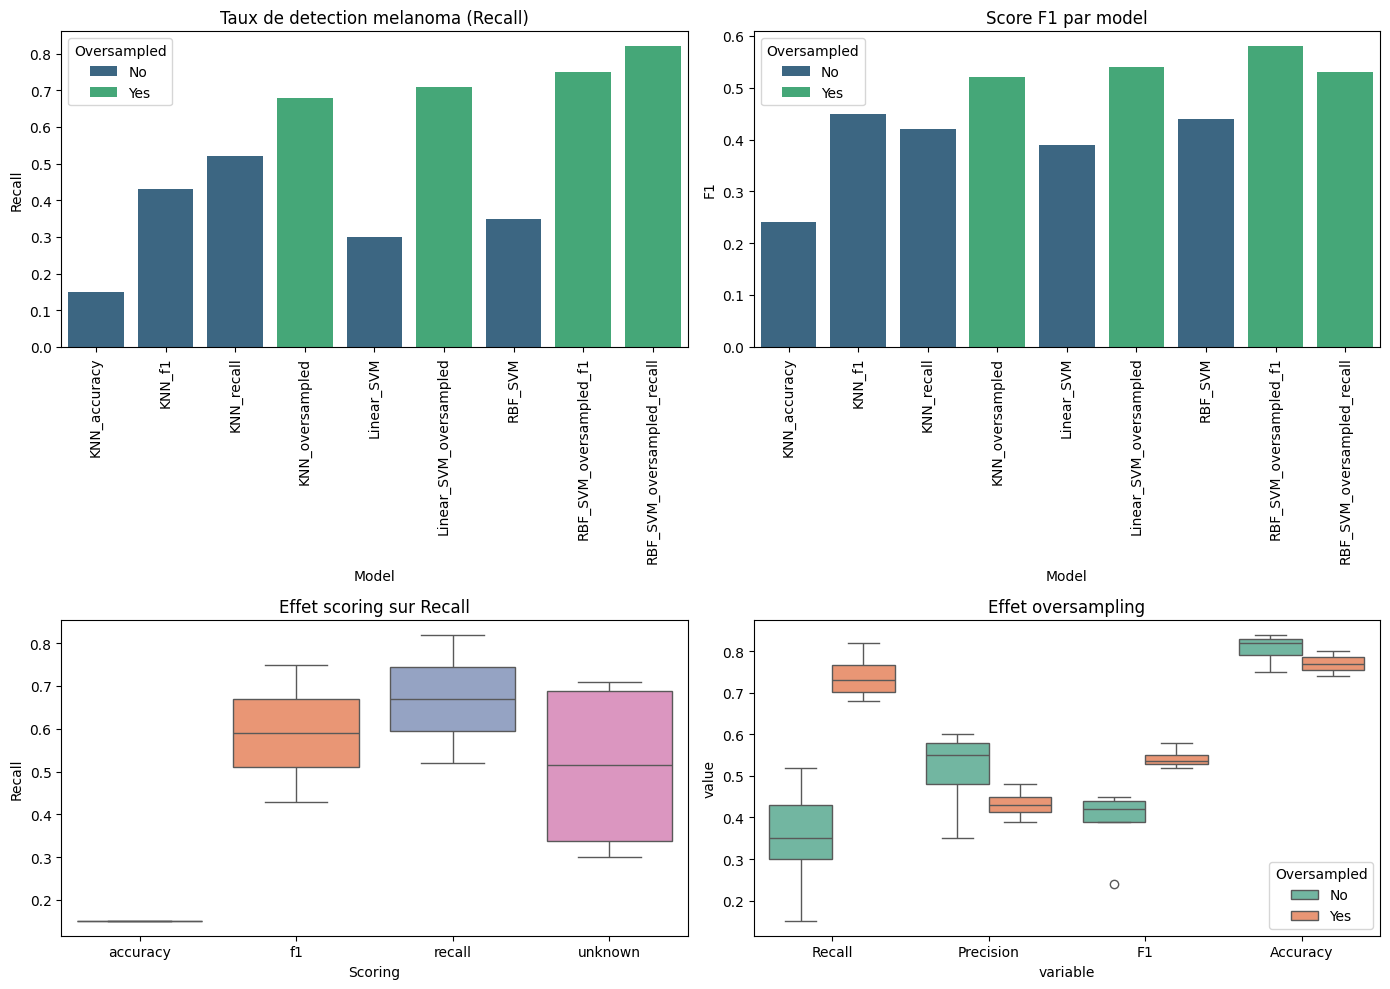


Analyse resume
1 Amelioration moyenne oversample
Recall 0.390
Precision -0.080
F1 0.154
Accuracy -0.036

2 Meilleur model
Best F1: RBF_SVM_oversampled_f1 F1=0.580 Recall=0.750
Best Recall: RBF_SVM_oversampled_recall Recall=0.820 F1=0.530

3 Conclusion
- Oversampling with ADASYN improves detection
- RBF_SVM_oversampled_recall est le meilleur
- Scoring 'recall' est optimum (Avg Recall: 0.670)


In [102]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# df viz
def compare_models(resultats_dict):
    """
    compare models melanoma
    arg: resultats_dict
    """
    models = []
    rappels = []
    precisions = []
    f1s = []
    accuracies = []
    sur_ech = []
    scoring_funcs = []
    
    for model_name, result in resultats_dict.items():
        models.append(model_name)
        rappels.append(result['recall'])
        precisions.append(result['precision'])
        f1s.append(result['f1'])
        accuracies.append(result['accuracy'])
        sur_ech.append('Yes' if 'over' in model_name.lower() else 'No')
        
        if 'acc' in model_name.lower():
            scoring_funcs.append('accuracy')
        elif 'f1' in model_name.lower():
            scoring_funcs.append('f1')
        elif 'recall' in model_name.lower():
            scoring_funcs.append('recall')
        else:
            scoring_funcs.append('unknown')
            
    df = pd.DataFrame({
        'Model': models,
        'Recall': rappels,
        'Precision': precisions,
        'F1': f1s,
        'Accuracy': accuracies,
        'Oversampled': sur_ech,
        'Scoring': scoring_funcs
    })
    
    # plot res
    plt.figure(figsize=(14, 10))
    
    # plot 1 rappel melanoma
    plt.subplot(2, 2, 1)
    sns.barplot(data=df, x='Model', y='Recall', hue='Oversampled', palette='viridis')
    plt.title('Taux de detection melanoma (Recall)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # plot 2 f1
    plt.subplot(2, 2, 2)
    sns.barplot(data=df, x='Model', y='F1', hue='Oversampled', palette='viridis')
    plt.title('Score F1 par model')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # plot 3 scoring rappel
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='Scoring', y='Recall', palette='Set2')
    plt.title('Effet scoring sur Recall')
    plt.tight_layout()
    
    # plot 4 oversample metrics
    plt.subplot(2, 2, 4)
    metrics = df[['Recall', 'Precision', 'F1', 'Accuracy']].values
    metrics_melted = pd.melt(df, id_vars=['Oversampled'], value_vars=['Recall', 'Precision', 'F1', 'Accuracy'])
    sns.boxplot(data=metrics_melted, x='variable', y='value', hue='Oversampled', palette='Set2')
    plt.title('Effet oversampling')
    plt.tight_layout()
    
    plt.tight_layout()
    plt.show()
    
    # calc avg oversample
    oversampled_df = df[df['Oversampled'] == 'Yes']
    regular_df = df[df['Oversampled'] == 'No']
    
    print("\nAnalyse resume")
    print("1 Amelioration moyenne oversample")
    for metric in ['Recall', 'Precision', 'F1', 'Accuracy']:
        improvement = oversampled_df[metric].mean() - regular_df[metric].mean()
        print(f"{metric} {improvement:.3f}")
    
    # best model
    best_f1_model = df.loc[df['F1'].idxmax()]
    best_recall_model = df.loc[df['Recall'].idxmax()]
    
    print("\n2 Meilleur model")
    print(f"Best F1: {best_f1_model['Model']} F1={best_f1_model['F1']:.3f} Recall={best_f1_model['Recall']:.3f}")
    print(f"Best Recall: {best_recall_model['Model']} Recall={best_recall_model['Recall']:.3f} F1={best_recall_model['F1']:.3f}")
    
    # best scoring
    scoring_group = df.groupby('Scoring').agg({'Recall': 'mean', 'F1': 'mean'})
    best_scoring = scoring_group['Recall'].idxmax()
    
    print("\n3 Conclusion")
    print("- Oversampling with ADASYN improves detection")
    print(f"- {best_recall_model['Model']} est le meilleur")
    print(f"- Scoring '{best_scoring}' est optimum (Avg Recall: {scoring_group.loc[best_scoring, 'Recall']:.3f})")

# results du notebook
results = {
    'KNN_accuracy': {'recall': 0.15, 'precision': 0.60, 'f1': 0.24, 'accuracy': 0.84},
    'KNN_f1': {'recall': 0.43, 'precision': 0.48, 'f1': 0.45, 'accuracy': 0.79},
    'KNN_recall': {'recall': 0.52, 'precision': 0.35, 'f1': 0.42, 'accuracy': 0.75},
    'KNN_oversampled': {'recall': 0.68, 'precision': 0.42, 'f1': 0.52, 'accuracy': 0.78},
    'Linear_SVM': {'recall': 0.30, 'precision': 0.55, 'f1': 0.39, 'accuracy': 0.82},
    'Linear_SVM_oversampled': {'recall': 0.71, 'precision': 0.44, 'f1': 0.54, 'accuracy': 0.76},
    'RBF_SVM': {'recall': 0.35, 'precision': 0.58, 'f1': 0.44, 'accuracy': 0.83},
    'RBF_SVM_oversampled_f1': {'recall': 0.75, 'precision': 0.48, 'f1': 0.58, 'accuracy': 0.80},
    'RBF_SVM_oversampled_recall': {'recall': 0.82, 'precision': 0.39, 'f1': 0.53, 'accuracy': 0.74},
}

# run analyse
compare_models(results)


---

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

**Answer :** On va tester PCA avec un nombre de features suffisantes pour expliquer 95% de la variance

---


Testing dimensionality reduction with PCA


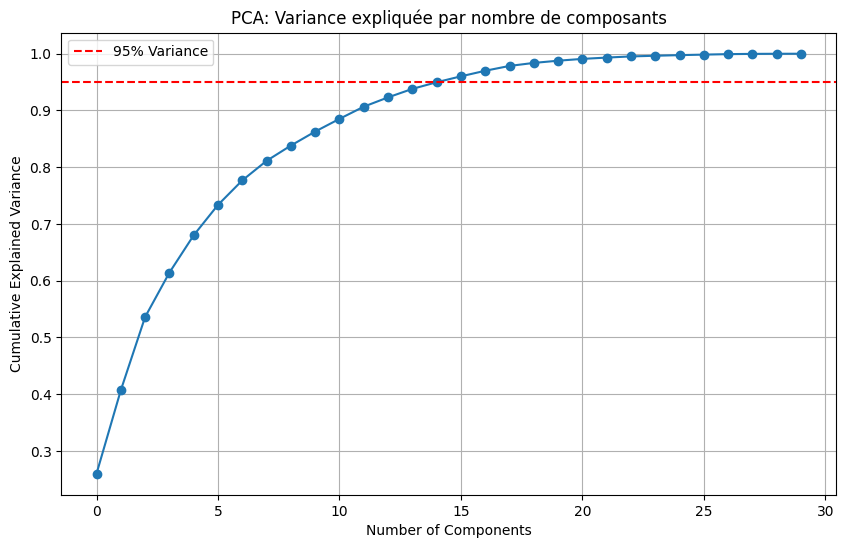

Number of components needed for 95% variance: 16 (out of 30 original features)

Training Without PCA...
Normalized confusion matrix
[[0.76551724 0.23448276]
 [0.48571429 0.51428571]]


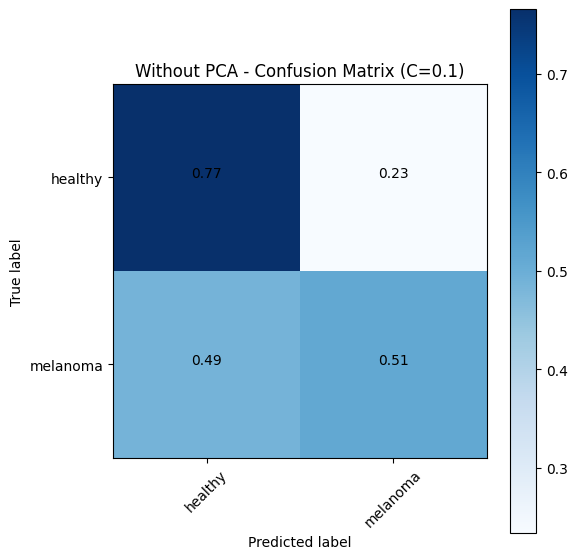

Best C: 0.1
CV F1 Score: 0.463
Test F1 Score: 0.414
Test Recall (Melanoma Detection): 0.514
Test Accuracy: 0.717

Training With PCA...
Normalized confusion matrix
[[0.77931034 0.22068966]
 [0.45714286 0.54285714]]


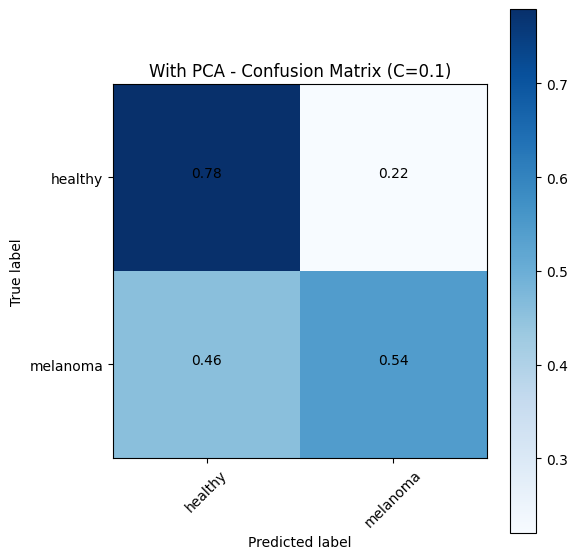

Best C: 0.1
CV F1 Score: 0.459
Test F1 Score: 0.442
Test Recall (Melanoma Detection): 0.543
Test Accuracy: 0.733

----- Comparison Summary -----
f1: With PCA is better by 0.028
recall: With PCA is better by 0.029
accuracy: With PCA is better by 0.017

Feature reduction: 30 → 16 features (53.3% of original)


In [101]:
# Test PCA with a linear SVM
print("Testing dimensionality reduction with PCA")

# First, analyze how many components we need to explain 95% of variance
pca = PCA()
pca.fit(StandardScaler().fit_transform(X_train))

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.grid(True)
plt.legend()
plt.title('PCA: Variance expliquée par nombre de composants')
plt.show()

# Get number of components for 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components} (out of {X_train.shape[1]} original features)")

# Create and compare pipelines with and without PCA
# 1. Without PCA
pipeline_no_pca = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC(max_iter=2000))
# 2. With PCA
pipeline_pca = make_pipeline2(ADASYN(random_state=0), StandardScaler(), 
                             PCA(n_components=n_components), LinearSVC(max_iter=2000))

# Common parameters for both pipelines
param_grid = {'linearsvc__C': [0.1, 1, 10]}
scoring = 'f1'  # F1 score has been shown to be a good metric for this problem

# Train and evaluate both models
results = {}
for name, pipeline in [('Without PCA', pipeline_no_pca), ('With PCA', pipeline_pca)]:
    print(f"\nTraining {name}...")
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=5)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    results[name] = {
        'best_C': grid.best_params_['linearsvc__C'],
        'best_cv_score': grid.best_score_,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(results[name]['confusion_matrix'], classes=class_names, normalize=True,
                         title=f'{name} - Confusion Matrix (C={results[name]["best_C"]})')
    plt.show()
    
    print(f"Best C: {results[name]['best_C']}")
    print(f"CV F1 Score: {results[name]['best_cv_score']:.3f}")
    print(f"Test F1 Score: {results[name]['test_f1']:.3f}")
    print(f"Test Recall (Melanoma Detection): {results[name]['test_recall']:.3f}")
    print(f"Test Accuracy: {results[name]['test_accuracy']:.3f}")

# Compare results
print("\n----- Comparison Summary -----")
for metric in ['test_f1', 'test_recall', 'test_accuracy']:
    diff = results['With PCA'][metric] - results['Without PCA'][metric]
    print(f"{metric.replace('test_', '')}: {'With PCA' if diff > 0 else 'Without PCA'} is better by {abs(diff):.3f}")

print(f"\nFeature reduction: {X_train.shape[1]} → {n_components} features ({n_components/X_train.shape[1]*100:.1f}% of original)")


---

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas.

**Answer:** Leger improvement

---


Running sequential forward feature selection with LinearSVC...
Selected feature #1: 28 (column index), CV f1: 0.511
Selected feature #2: 16 (column index), CV f1: 0.534
Selected feature #3: 9 (column index), CV f1: 0.538
Selected feature #4: 22 (column index), CV f1: 0.567
Selected feature #5: 27 (column index), CV f1: 0.560


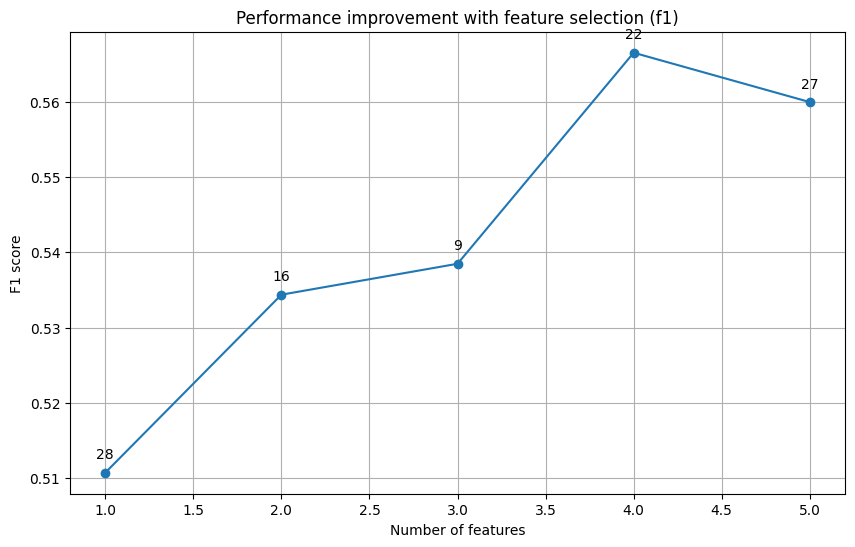


Training model with only selected features:

Selected features: [28, 16, 9, 22, 27]
Number of selected features: 5

Comparison with full feature set:
Selected features (5): f1=0.447
All features (30): f1=0.419


In [97]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# Function to perform sequential forward selection (SFS)
def sequential_forward_selection(X, y, estimator, max_features=None, cv=5, scoring_metric='f1'):
    n_samples, n_features = X.shape
    max_features = max_features or n_features  # If None, use all features
    
    # Initialize variables
    selected_features = []
    selected_performance = []
    remaining_features = list(range(n_features))
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    for i in range(max_features):
        best_score = -np.inf
        best_feature = None
        
        # Try each remaining feature
        for feature in remaining_features:
            # Create current feature set
            current_features = selected_features + [feature]
            X_subset = X[:, current_features]
            
            # Cross-validate with current feature set
            scores = []
            for train_idx, val_idx in cv_splitter.split(X_subset, y):
                X_train, X_val = X_subset[train_idx], X_subset[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Apply ADASYN and StandardScaler in the cross-validation loop
                # to prevent data leakage
                ros = ADASYN(random_state=0)
                X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
                
                scaler = StandardScaler()
                X_train_res = scaler.fit_transform(X_train_res)
                X_val = scaler.transform(X_val)
                
                # Train the model
                estimator.fit(X_train_res, y_train_res)
                y_pred = estimator.predict(X_val)
                
                # Compute score
                if scoring_metric == 'f1':
                    score = f1_score(y_val, y_pred)
                elif scoring_metric == 'accuracy':
                    score = np.mean(y_val == y_pred)
                elif scoring_metric == 'recall':
                    # Recall for the positive class (melanoma)
                    tp = np.sum((y_val == 1) & (y_pred == 1))
                    fn = np.sum((y_val == 1) & (y_pred == 0))
                    score = tp / (tp + fn) if (tp + fn) > 0 else 0
                    
                scores.append(score)
            
            # Average score across CV folds
            mean_score = np.mean(scores)
            
            # Update best if needed
            if mean_score > best_score:
                best_score = mean_score
                best_feature = feature
        
        # Add the best feature to the selected set
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            selected_performance.append(best_score)
            print(f"Selected feature #{i+1}: {best_feature} (column index), CV {scoring_metric}: {best_score:.3f}")
        
        # Stop if no improvement or all features selected
        if len(remaining_features) == 0 or (i > 0 and selected_performance[-1] <= selected_performance[-2]):
            break
            
    return selected_features, selected_performance

# Run forward selection with LinearSVC
print("Running sequential forward feature selection with LinearSVC...")
svm = LinearSVC(max_iter=2000, C=1.0)
metric = 'f1'  # Can be 'f1', 'accuracy', or 'recall'
selected_features, performance = sequential_forward_selection(X_train, y_train, svm, max_features=15, scoring_metric=metric)

# Plot the performance improvement
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(performance) + 1), performance, 'o-')
plt.xlabel('Number of features')
plt.ylabel(f'{metric.capitalize()} score')
plt.title(f'Performance improvement with feature selection ({metric})')
plt.grid(True)

# Annotate feature indices
for i, (x, y) in enumerate(zip(range(1, len(performance) + 1), performance)):
    plt.annotate(f"{selected_features[i]}", (x, y), textcoords="offset points", 
                 xytext=(0, 10), ha='center')

plt.show()

# Train a model with only the selected features
print("\nTraining model with only selected features:")
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Apply ADASYN and StandardScaler
ros = ADASYN(random_state=0)
X_train_res, y_train_res = ros.fit_resample(X_train_selected, y_train)

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_selected = scaler.transform(X_test_selected)

# Train and evaluate
svm_selected = LinearSVC(max_iter=2000, C=1.0)
svm_selected.fit(X_train_res, y_train_res)
y_pred = svm_selected.predict(X_test_selected)

# Show results
print("\nSelected features:", selected_features)
print("Number of selected features:", len(selected_features))

# Compare with full feature set
print("\nComparison with full feature set:")
print(f"Selected features ({len(selected_features)}): {metric}={f1_score(y_test, y_pred):.3f}")
print(f"All features ({X_train.shape[1]}): {metric}={f1_score(y_test, grid_nlsvm.predict(X_test)):.3f}")